In [155]:
import torch
import numpy as np
from torchsummary import summary

from data import FlagDataset
from torch.utils.data import DataLoader
from utils import get_device

In [2]:
DEVICE = get_device()

In [164]:
class Encoder(torch.nn.Module):
    def __init__(self, flag_size: int, latent_size: int):
        super().__init__()
        self.input_size = flag_size
        self.conv1 = torch.nn.Conv2d(4, 128, 3, 1, padding=1)
        self.maxpool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(128, 64, 3, stride=1, padding=1)
        self.maxpool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(64, 64, 5, stride=2, padding=2)
        self.maxpool3 = torch.nn.MaxPool2d(2, 2)
        self.conv4 = torch.nn.Conv2d(64, 32, 5, stride=2, padding=2)
        self.maxpool4 = torch.nn.MaxPool2d(2, 2)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.pre_flatten_size = self.pre_flatten(torch.zeros(1, 4, self.input_size, self.input_size)).shape[1:]
        self.linear = torch.nn.Linear(np.prod(self.pre_flatten_size), latent_size)
        
    def pre_flatten(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool3(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool4(x)
        return x
        
    def forward(self, x: torch.Tensor):
        x = self.pre_flatten(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        x = self.sigmoid(x)
        return x
    
class Decoder(torch.nn.Module):
    def __init__(self, latent_size: int, pre_flatten_size: list[int]):
        super().__init__()
        self.input_size = latent_size
        self.pre_flatten_size = pre_flatten_size
        self.linear = torch.nn.Linear(latent_size, np.prod(pre_flatten_size))
        self.unpool1 = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv1 = torch.nn.ConvTranspose2d(32, 64, 5, stride=2, padding=2, output_padding=1)
        self.unpool2 = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv2 = torch.nn.ConvTranspose2d(64, 64, 5, stride=2, padding=2, output_padding=1)
        self.unpool3 = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv3 = torch.nn.ConvTranspose2d(64, 128, 3, stride=1, padding=1)
        self.unpool4 = torch.nn.Upsample(scale_factor=2, mode='nearest')
        self.deconv4 = torch.nn.ConvTranspose2d(128, 4, 3, stride=1, padding=1)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = x.view(x.size(0), *self.pre_flatten_size)
        x = self.unpool1(x)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.unpool2(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.unpool3(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.unpool4(x)
        x = self.deconv4(x)
        x = self.sigmoid(x)
        return x

In [4]:
flag_dataset = FlagDataset("flags", device=DEVICE)
print(flag_dataset.device)

flag_dataloader = DataLoader(flag_dataset, batch_size=32, shuffle=True)
def cycle(iterable, n):
    while True:
        for x in iterable:
            yield x

cuda


In [165]:
latent_size = 64
encoder = Encoder(128, latent_size=latent_size).to(DEVICE)
pre_flatten_size = encoder.pre_flatten_size
print(latent_size, pre_flatten_size)
decoder = Decoder(latent_size, pre_flatten_size).to(DEVICE)

summary(encoder, (4, 128, 128))
summary(decoder, (latent_size,))

64 torch.Size([32, 2, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 128, 128]           4,736
              ReLU-2        [-1, 128, 128, 128]               0
         MaxPool2d-3          [-1, 128, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          73,792
              ReLU-5           [-1, 64, 64, 64]               0
         MaxPool2d-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 16, 16]         102,464
              ReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
           Conv2d-10             [-1, 32, 4, 4]          51,232
             ReLU-11             [-1, 32, 4, 4]               0
        MaxPool2d-12             [-1, 32, 2, 2]               0
           Linear-13                   [-1, 64]           8,256
          Sig

In [6]:
# x = torch.nn.Upsample(scale_factor=2, mode="nearest")(torch.rand(1, 8, 4, 4))
# print(x.shape)
# x = torch.nn.ConvTranspose2d(8, 16, 3, stride=2, padding=1, output_padding=1)(x)
# print(x.shape)
# x = torch.nn.Upsample(scale_factor=2, mode="nearest")(x)
# print(x.shape)
# x = torch.nn.ConvTranspose2d(16, 32, 3, stride=2, padding=1, output_padding=1)(x)
# print(x.shape)
# x = torch.nn.Upsample(scale_factor=2, mode="nearest")(x)
# print(x.shape)
# x = torch.nn.ConvTranspose2d(32, 4, 3, stride=1, padding=1)(x)
# print(x.shape)

In [7]:
# x = torch.nn.Conv2d(4, 32, 3, 1, padding=1)(torch.rand(1, 4, 128, 128))
# print(x.shape)
# x = torch.nn.MaxPool2d(2, 2)(x)
# print(x.shape)
# x = torch.nn.Conv2d(32, 16, 3, stride=2, padding=1)(x)
# print(x.shape)
# x = torch.nn.MaxPool2d(2, 2)(x)
# print(x.shape)
# x = torch.nn.Conv2d(16, 8, 3, stride=2, padding=1)(x)
# print(x.shape)
# x = torch.nn.MaxPool2d(2, 2)(x)
# print(x.shape)

In [370]:
batches = 1000

encoder.train()
decoder.train()
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
running_loss = 0
print_every = 100
for i, batch in enumerate(cycle(flag_dataloader, batches)):
    optimizer.zero_grad()
    x = batch[0]
    z = encoder(x)
    x_hat = decoder(z)
    
    loss = torch.nn.functional.binary_cross_entropy(x_hat, x)
    loss.backward()
    running_loss += loss.item()
    
    if i % print_every == 0:
        print(f"Batch {i}: Loss {running_loss / print_every}")
        running_loss = 0
    
    optimizer.step()

Batch 0: Loss 0.0014440195262432098
Batch 100: Loss 0.16883766666054725
Batch 200: Loss 0.15824759870767593
Batch 300: Loss 0.158296340405941
Batch 400: Loss 0.15772199183702468
Batch 500: Loss 0.15795916929841042
Batch 600: Loss 0.15779584065079688
Batch 700: Loss 0.158347008228302
Batch 800: Loss 0.1581678456068039
Batch 900: Loss 0.1594243237376213
Batch 1000: Loss 0.1586337548494339
Batch 1100: Loss 0.1590852928161621
Batch 1200: Loss 0.15882210180163384
Batch 1300: Loss 0.1584829159080982
Batch 1400: Loss 0.1615827961266041
Batch 1500: Loss 0.16120166465640068
Batch 1600: Loss 0.1577674177289009
Batch 1700: Loss 0.15756258442997934
Batch 1800: Loss 0.1572180810570717
Batch 1900: Loss 0.1578959584236145
Batch 2000: Loss 0.15855489805340767
Batch 2100: Loss 0.1598656529188156
Batch 2200: Loss 0.15773764595389367
Batch 2300: Loss 0.1576912871003151
Batch 2400: Loss 0.15710124775767326
Batch 2500: Loss 0.15758884459733963
Batch 2600: Loss 0.1596645326912403
Batch 2700: Loss 0.15846869

KeyboardInterrupt: 

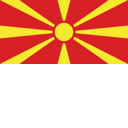

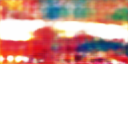

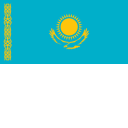

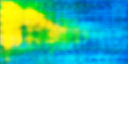

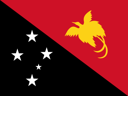

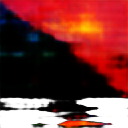

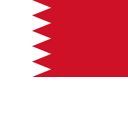

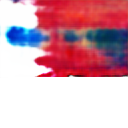

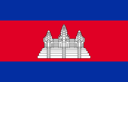

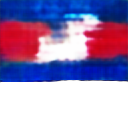

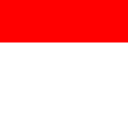

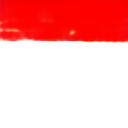

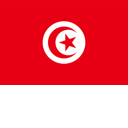

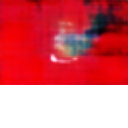

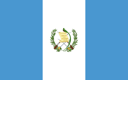

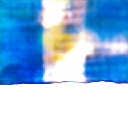

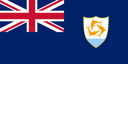

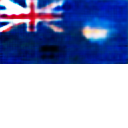

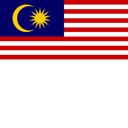

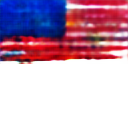

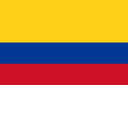

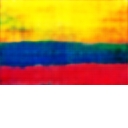

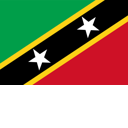

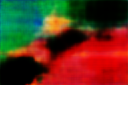

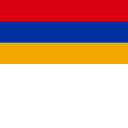

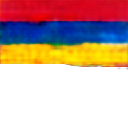

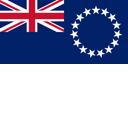

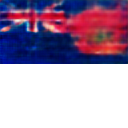

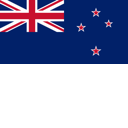

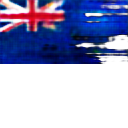

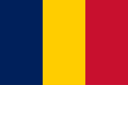

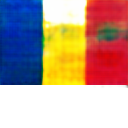

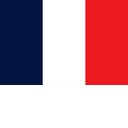

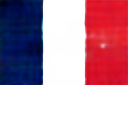

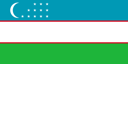

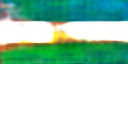

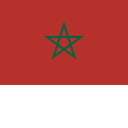

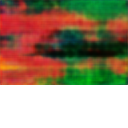

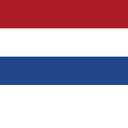

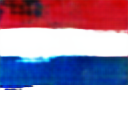

In [390]:
encoder.eval()
decoder.eval()
from PIL import Image
from torchvision.transforms import ToPILImage
to_pil = ToPILImage()

for i in range(20):
    x = flag_dataset[i][0]
    to_pil(x).show()
    z = encoder(x.unsqueeze(0))
    z = z + (torch.randn_like(z)-0.5)*0.1
    im = decoder(z).squeeze(0)
    im = to_pil(im)
    im.show()

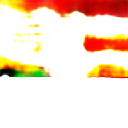

In [378]:
x = torch.rand(latent_size).to(DEVICE)
x = x.round()
im = decoder(x.unsqueeze(0)).squeeze(0)
im = to_pil(im)
im.show()

In [391]:
torch.save(encoder.state_dict(), "encoder.pth")
torch.save(decoder.state_dict(), "decoder.pth")